# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

In [1]:
import pandas
import emcee
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve as lk
from lightkurve.lightcurve import LightCurve
from bring_the_func import *
import os

First we need to read in the photometry data. This notebook assumes that photometry has been performed with [AstroImageJ](https://www.astro.louisville.edu/software/astroimagej/) and a table of measurements has been saved as a .csv file. In this example, I also pull the preliminary planet and star parameters from a table that I created, but you can insert your parameters however you wish.

In [2]:
os.chdir('/Users/willwaalkes/Desktop/PhD_Thesis/TFOP/Transit_Analysis/')

TOI = 2094.01

In [4]:
data = pandas.read_csv('Data/measurements/TIC356016119-01_20210601_APO_ip_measurements-cut1.csv',comment='#')

In [5]:
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')
TIC_IDs = params['TIC_ID']
TOIs = params['TOI']
err_kludge = 1.5*1.5

In [6]:
for i in range(len(TOIs)):
    if TOIs[i] == TOI:
        index = i

tic_id = TIC_IDs[index]
toi = TOIs[index]
observatory = 'APO'
print('TIC ',tic_id)
print('TOI ',toi)

TIC  356016119.0
TOI  2094.01


The AIJ Table does not automatically include BJD times so you will need to convert JD to BJD before using this notebook (as we did here, using http://astroutils.astronomy.ohio-state.edu/time/utc2bjd.html).

Let's take a look at the data!

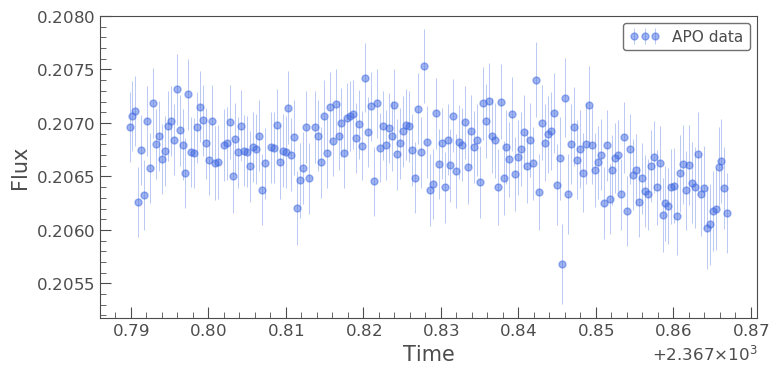

In [7]:
flux = np.array(data['rel_flux_T1'])
error = np.array(data['rel_flux_err_T1'])*err_kludge #inflates the error bars to give a best fit chi2=1
times = np.array(data['BJD_TDB'])
airmass = np.array(data['AIRMASS'])
xpos = np.array(data['X(IJ)_T1'])
ypos =np.array(data['X(IJ)_T1'])
comp_flux = np.array(data['tot_C_cnts'])

offset = 2457000
times = times-offset # This is just a constant offset to make the x-axis more readable

lc = LightCurve(time = times, flux = flux, flux_err = error)#.remove_outliers(sigma=3)

lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',
            markersize='5',normalize=False)

Now let's turn this into a **lightkurve** object

## **The following cell is where you should define all of the specific parameters for the system you are studying. After specifying all of these parameters, the rest of the code should work without fiddling.**

In [8]:
planet_period = np.array(params['P (days)'][index]) # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = 89.1 #inclination in degrees
C1 = np.median(lc.flux) #C1 and C2 are the airmass correction parameters
C2 = 0.0
depth = C1*(1-float(ppm_depth)/1e6)

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n) + np.array(Epoch)


for i in range(len(n)):
    if (mid_transit_times[i] >= lc.time[0]-1):
        if (mid_transit_times[i] <= lc.time[-1]+1):
            
            expected_t0 = mid_transit_times[i]
            print(f"Anticipated mid-transit time = {expected_t0:.6f}")
            print(f"Anticipated depth = {depth:.4f}")

Anticipated mid-transit time = 2367.818618
Anticipated depth = 0.2064


In [9]:
(((expected_t0-Epoch)/planet_period)*0.000385) # Propagated uncertainty

0.013860000000000004

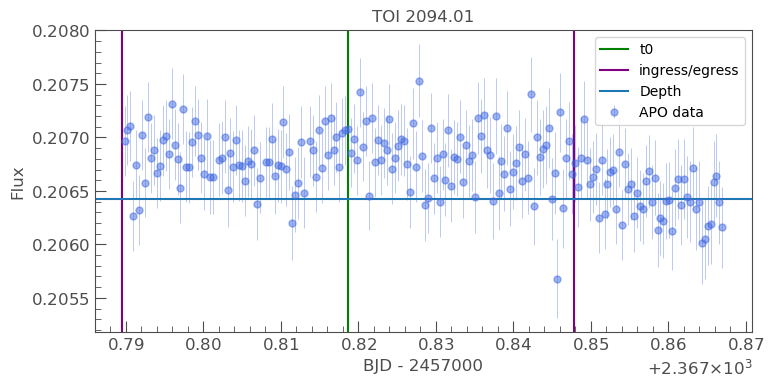

In [10]:
lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',markersize='5',
           normalize=False)
plt.title('TOI {}'.format(toi))
plt.xlabel('BJD - {}'.format(offset),fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.axvline(expected_t0,label='t0',color='g')
plt.axvline(expected_t0-(planet_duration/24.0)/2.0,label='ingress/egress',color='purple')
plt.axvline(expected_t0+(planet_duration/24.0)/2.0,color='purple')
plt.axhline(depth,label='Depth')
plt.legend()
plt.savefig('Figs/TOI_{}_NoFit.png'.format(toi))
plt.show()

In [11]:
# star_met = 0
# LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met)
# LD = LD_coeff[0]
# print(LD_coeff)
# print('--------')
# print(LD_err)

LD_coeff = [[0.40189188, 0.27528391]]
LD_err = [[0.00587292, 0.00961813]]
LD = LD_coeff[0]

The next cell is used to test that lnprob is working properly. If you feed it the expected arguments for Rp and t$_0$, it should spit out a reasonable (read: fininte and non-negative) probability value and an appropriate looking model overlaid on the data.

4225.577540357437


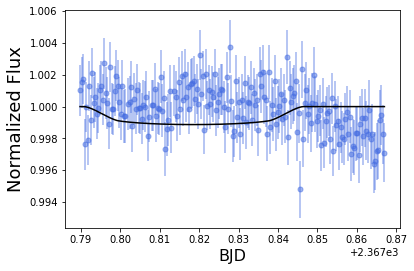

In [12]:
theta = [C1, C2, planet_radius, expected_t0]
static_params = [planet_radius, planet_period, planet_a, planet_i,
                 expected_t0, LD, offset, observatory, airmass, toi]

a = lnprob(theta, lc, planet_period, LD, airmass, planet_a, expected_t0, plot = True)
print(a)

Now we are ready to define and run an MCMC, using Dan Foreman-Mackey's [emcee](http://dfm.io/emcee/current/):

In [13]:
# intialize some walkers
ndim, nwalkers, nsteps = 4, 100, 10000
burnin = int(0.3*nsteps)

# these are initial parameters
C1_init = np.random.uniform(C1, C1, nwalkers)
C2_init = np.random.uniform(0.0,0.000001, nwalkers)
Rp_init = np.random.uniform(planet_radius-0.02, planet_radius+0.02, nwalkers)
t0_init = np.random.uniform(expected_t0-0.0139,expected_t0+0.0139, nwalkers)
#a_init = np.random.uniform(planet_a-0.005, planet_a+0.005, nwalkers)
#i_init = np.random.uniform(planet_i-0.005, planet_i+0.005, nwalkers)

labels = ['C1','C2','Rp/R*','T0']#,'a/R*','i (deg)'] #this is for the corner plot

p0 = np.transpose([C1_init, C2_init, Rp_init, t0_init])

In [14]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (lc,planet_period,LD,airmass,planet_a, expected_t0))
result = sampler.run_mcmc(p0, nsteps)

emcee: Exception while calling your likelihood function:
  params: [2.06754000e-01 4.26186371e-04 3.92254463e-02 2.36786386e+03]
  args: (<lightkurve.lightcurve.LightCurve object at 0x7fedea23ced0>, array(18.791343), [0.40189188, 0.27528391], array([1.256291, 1.256204, 1.256106, 1.256024, 1.255932, 1.255855,
       1.255769, 1.255684, 1.255615, 1.255537, 1.255472, 1.2554  ,
       1.255338, 1.255272, 1.255216, 1.255155, 1.255095, 1.255047,
       1.254991, 1.25495 , 1.254902, 1.254857, 1.254818, 1.254782,
       1.25475 , 1.254716, 1.254685, 1.254659, 1.254634, 1.254614,
       1.254594, 1.254564, 1.254552, 1.254542, 1.254537, 1.254533,
       1.254531, 1.254533, 1.254537, 1.254544, 1.254554, 1.254564,
       1.254581, 1.2546  , 1.254618, 1.254641, 1.254693, 1.254721,
       1.254755, 1.254787, 1.254826, 1.254871, 1.25491 , 1.25496 ,
       1.255004, 1.255056, 1.255105, 1.255165, 1.255227, 1.255285,
       1.255412, 1.255485, 1.25555 , 1.25563 , 1.255699, 1.255785,
       1.255872, 1.2

Traceback (most recent call last):
  File "/Users/willwaalkes/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/willwaalkes/Desktop/PhD_Thesis/TFOP/TIC356016119/bring_the_func.py", line 113, in lnprob
    chisq = np.sum((lc.flux - model)**2/(lc.flux_err)**2)
KeyboardInterrupt


KeyboardInterrupt: 

In [16]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
C1_sam, C2_sam, Rp_sam, t0_sam = samples

sig1_C1 = np.percentile(C1_sam, [16., 50., 84.])
sig1_C2 = np.percentile(C2_sam, [16., 50., 84.])
sig1_Rp = np.percentile(Rp_sam, [16., 50., 84.])
sig1_t0 = np.percentile(t0_sam, [16., 50., 84.])

parameters = [sig1_C1[1],sig1_C2[1],sig1_Rp[1],sig1_t0[1]]

best_fit_model = (sig1_C1[1] + sig1_C2[1]*(airmass-1))*BATMAN(Rp = sig1_Rp[1],
                                                              t0 = sig1_t0[1],
                                                              LD = LD,
                                                              t = lc.time)
reduced_chisq = np.sum((lc.flux - best_fit_model)**2/(lc.flux_err)**2)/(len(lc.flux)-4)     
err_kludge = np.sqrt(reduced_chisq)
print(err_kludge)

np.savetxt(fname=f'Data/TOI_{toi}_samples.txt',X=samples)

1.0650277197011555


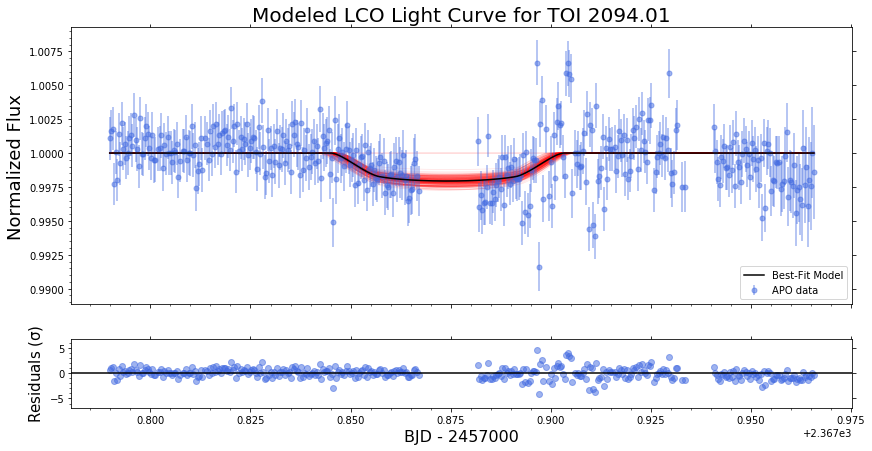

In [17]:
light_curve(lc, parameters, sampler, static_params, nsteps, Epoch, tic_id)

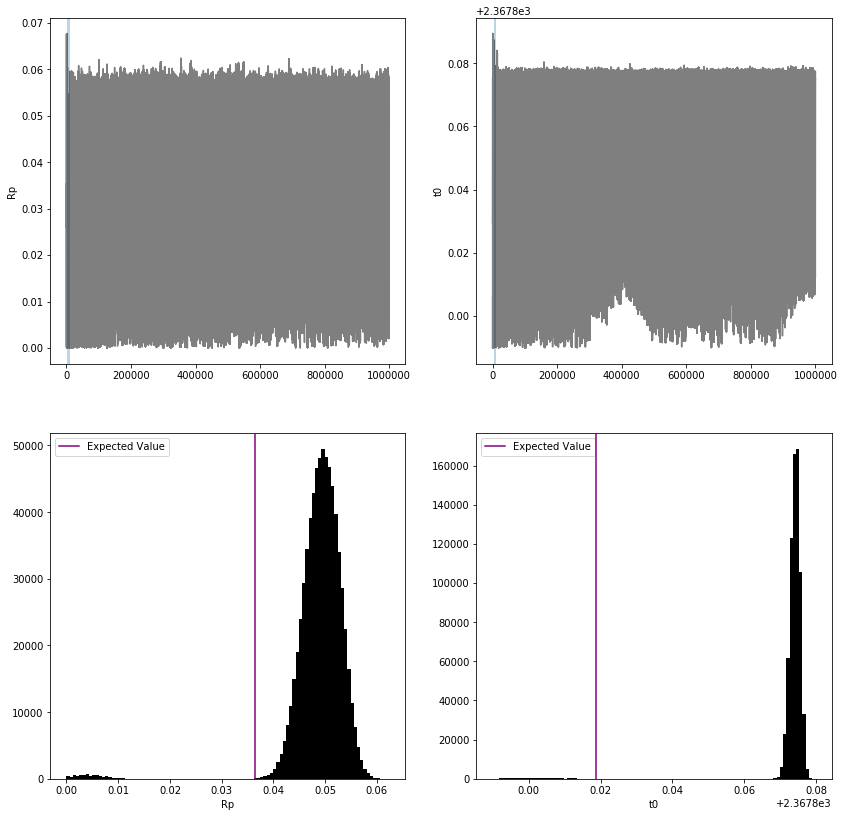

In [18]:
plot_chain(sampler, static_params, start=burnin, stop=nsteps)

In [19]:
for i in range(len(samples)):
    tau_f = emcee.autocorr.integrated_time(samples[i])
    print((nsteps-burnin)/tau_f)

[7000.]
[13.42656718]
[1.83010567]
[1.14080019]


RMS at 10 min binning = 0.0016642
Error at 10 min binning = 0.0002354


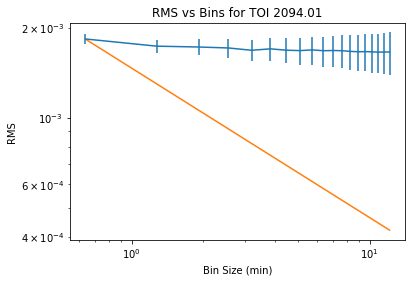

In [20]:
rms_plot(lc, parameters, static_params)

In [21]:
#corner(samples, labels, toi)

In [22]:
# print('C1 = {:.5f}'.format(sig1_C1[1]),
#       '+ {:.5f}'.format(sig1_C1[2]-sig1_C1[1]),
#       '- {:.5f}'.format(sig1_C1[1]-sig1_C1[0]))

# print('C2 = {:.5f}'.format(sig1_C2[1]),
#       '+ {:.5f}'.format(sig1_C2[2]-sig1_C2[1]),
#       '- {:.5f}'.format(sig1_C2[1]-sig1_C2[0]))

print('Flux Deficit at Mid-Transit = {:.3f} ppt'.format((
      1-np.amin(best_fit_model/(sig1_C1[1] + sig1_C2[1]*(airmass-1))))*1000))

print('Rp/R* = {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('Rp (R_E) = {:.3f}'.format(sig1_Rp[1]*star_radius*109.168),
      '+ {:.3f}'.format((sig1_Rp[2]-sig1_Rp[1])*star_radius*109.168),
      '- {:.3f}'.format((sig1_Rp[1]-sig1_Rp[0])*star_radius*109.168))

# print('a/R* = {:.3f}'.format(sig1_A[1]),
#       '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
#       '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

# print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
#       '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
#       '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

#print('Impact parameter (b) = {:.3f}'.format(np.cos((sig1_Inc[1])*np.pi/180)*sig1_A[1]))

print('Mid-Transit Time = {:.6f}'.format(offset+sig1_t0[1]),
      '+ {:.6f}'.format(sig1_t0[2]-sig1_t0[1]),
      '- {:.6f}'.format(sig1_t0[1]-sig1_t0[0]))

print(f"Anticipated mid-transit time = {(offset+expected_t0):.6f}")

print(f"duration = {planet_period/(2*np.pi)/(planet_a)*24:.3f} hours")

results = Table({'rp':[sig1_Rp[1]],
                 'drp':[sig1_Rp[1]-sig1_Rp[0]],
                 't0':[sig1_t0[1]],
                 'dt0':[sig1_t0[1]-sig1_t0[0]]},
                names=['rp','drp','t0','dt0'])
ascii.write(results,f'Data/TOI_{toi}_bestfitparams.txt')

Flux Deficit at Mid-Transit = 2.016 ppt
Rp/R* = 0.0494 + 0.0033 - 0.0036
Rp (R_E) = 2.033 + 0.138 - 0.148
Mid-Transit Time = 2459367.874208 + 0.001304 - 0.001477
Anticipated mid-transit time = 2459367.818618
duration = 1.264 hours
